#### Forecasting top20 items from orderproducts


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from tsa_utils import *
df = pd.read_csv('../data/orderproducts_top20.csv', parse_dates=[1], infer_datetime_format=True)
df.head()

,order_id,order_date,order_total_price,product_price,order_discounts,product_discount,order_status,product_title,product_sku,product_quantity,product_category,weekdays,sch_holidays
0,20570,2018-01-01,449.97,249.99,yes,0.00,fulfilled,Vertigo™ Semi-Hollow,M80-VHB-BLK,1,Electric Guitar Cases & Gig Bags,1,Non Holidays
1,20570,2018-01-01,449.97,89.99,yes,0.00,fulfilled,The Tick™ 2.0 Black,M80-TICK-V2-BLK,1,Pedals & Pedalboards Cases & Gig Bags,1,Non Holidays
2,20556,2018-01-02,249.99,249.99,yes,0.00,fulfilled,Vertigo™ Semi-Hollow,M80-VHB-BLK,1,Electric Guitar Cases & Gig Bags,2,Non Holidays
3,20554,2018-01-02,NaN,229.99,no,229.99,fulfilled,The FlyBy,EFX-FLY-BLK,1,DJ Equipment Cases & Gig Bags,2,Non Holidays
4,20573,2018-01-01,249.99,249.99,yes,0.00,fulfilled,Vertigo™ Electric Guitar,M80-VEG-BLK,1,Electric Guitar Cases & Gig Bags,1,Non Holidays


In [2]:
prod_monthly = pd.crosstab(df['order_date'], df['product_sku']).resample('M').sum()
prod_monthly = prod_monthly['2018-01':'2021-02']

In [3]:
items = prod_monthly.columns

#### Test time series on one item

In [4]:
data = prod_monthly['2018':'2020']['EFX-FLY-BLK']

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='additive')

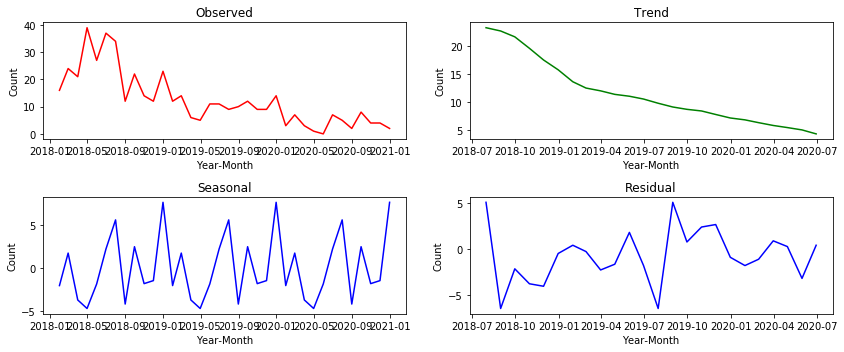

In [6]:
# using subplot function and creating plot one
plt.figure(figsize=(12,5))

# row 2, column 1, count 1
plt.subplot(2, 2, 1)
plt.plot(result.observed, 'r')
plt.title('Observed')
plt.xlabel('Year-Month')
plt.ylabel('Count')
  
# using subplot function and creating plot two
# row 2, column 1, count 2
plt.subplot(2, 2, 2)
plt.plot(result.trend, 'g')
plt.title('Trend')
plt.xlabel('Year-Month')
plt.ylabel('Count')

# using subplot function and creating plot two
# row 2, column 1, count 2
plt.subplot(2, 2, 3)
plt.plot(result.seasonal, 'b')
plt.title('Seasonal')
plt.xlabel('Year-Month')
plt.ylabel('Count')

# using subplot function and creating plot two
# row 2, column 1, count 2
plt.subplot(2, 2, 4)
plt.plot(result.resid, 'b')
plt.title('Residual')
plt.xlabel('Year-Month')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [7]:
### Plotting the AR curve

**he AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [7]:
from pmdarima.arima import auto_arima

# Select the best model using auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print('aic =', stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=167.134, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=166.319, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=165.435, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=165.164, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=163.954, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=165.164, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=167.164, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=165.938, Time=0.04 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=165.869, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=164.449, Time=0.03 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=165.952, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 0.557 seconds
aic = 163.95356575099117


#### Train Test Split
Use the best model derived above

In [14]:
train = data.loc['2018':'2019']  # 24 months
test  = data.loc['2020']  # 12 months

stepwise_model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [8]:
future_forecast = stepwise_model.predict(n_periods=12)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

# set forecast to 0 if forecast is < 0 and rounding up the numbers from floating to integer
future_forecast['Pred_Adj'] = [ 0 if x < 0 else round(x) for x in future_forecast['Prediction']]

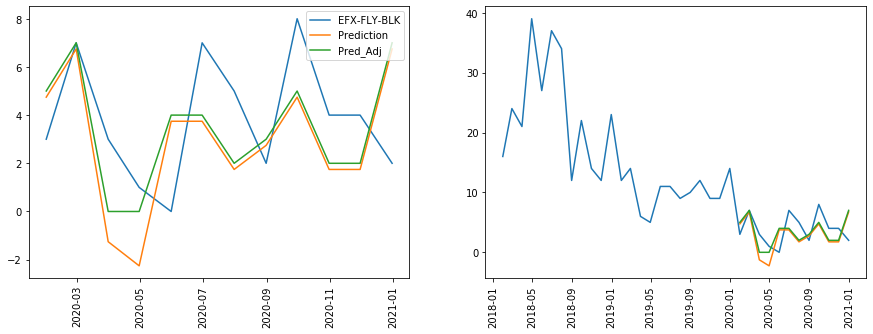

In [9]:
temp = pd.concat([test,future_forecast], axis=1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)  # row 1, column 1, count 1
plt.plot(temp)
plt.xticks(rotation=90)
plt.legend(temp.columns, loc='upper right')

plt.subplot(1, 2, 2) # row 1, column 2, count 1
plt.plot(pd.concat([data,future_forecast],axis=1))
plt.xticks(rotation=90)

plt.show()

In [22]:
#### Forecasting the last 3 months of the period for all the top 20 items

In [26]:
# items are the names of the top20 items
test_predict = []
mse_list = []
results =  pd.DataFrame()
for item in items:
    data = prod_monthly[item]
    train = data.iloc[:-3]
    test  = data.iloc[-3:]
    
    # Select the best model using auto_arima
    stepwise_model = auto_arima(data[0:36], start_p=1, start_q=1,
                               max_p=2, max_q=2, m=12,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True,
                               parallel=True)
    #print('aic =', stepwise_model.aic())
    stepwise_model.fit(train)
    forecast = stepwise_model.predict(n_periods=3)
    adj_forecast = [ 0 if x < 0 else int(round(x)) for x in forecast ]
    item_name = [item for x in range(3)]
    res = pd.DataFrame(zip(np.array(test), np.array(adj_forecast), item_name), 
                       index=['m+1','m+2','m+3'], columns=['test', 'predict', 'item'])
    results = pd.concat([results,res], axis=0)
print(results)

     test  predict             item
m+1     2        9      EFX-FLY-BLK
m+2     2        0      EFX-FLY-BLK
m+3     2        2      EFX-FLY-BLK
m+1     3        3       M80-2B-BLK
m+2     1        0       M80-2B-BLK
m+3     1        3       M80-2B-BLK
m+1     5        3       M80-2G-BLK
m+2     5        0       M80-2G-BLK
m+3     4        2       M80-2G-BLK
m+1     7        0       M80-AC-BLK
m+2     0        0       M80-AC-BLK
m+3     0        0       M80-AC-BLK
m+1     1        5       M80-AD-BLK
m+2     3        6       M80-AD-BLK
m+3     1        4       M80-AD-BLK
m+1     0        3    M80-BTY-BLK-L
m+2     3        0    M80-BTY-BLK-L
m+3     1        1    M80-BTY-BLK-L
m+1     4       12    M80-BTY-BLK-S
m+2     0        0    M80-BTY-BLK-S
m+3     2        0    M80-BTY-BLK-S
m+1     2        0       M80-EB-BLK
m+2     3        0       M80-EB-BLK
m+3     1        0       M80-EB-BLK
m+1     0        5       M80-EG-BLK
m+2     2        0       M80-EG-BLK
m+3     0        0       M80

In [27]:
results.to_csv('../data/top20predictions_last3months.csv')

#### Walk forward validation

In [38]:
# items are the names of the top20 items
test_predict = []
mse_list = []
results =  pd.DataFrame()
for item in items:
    data = prod_monthly[item]
    train = data.iloc[:-3]
    test  = data.iloc[-3:]
    
    # Select the best model using auto_arima
    history = [x for x in train]
    forecast = []
    for t in range(len(test)):
        stepwise_model = auto_arima(history, start_p=1, start_q=1,
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        stepwise_model.fit(history)
        yhat = float(stepwise_model.predict()[0])
        if yhat < 0:
            adj_yhat = 0
        else:
            adj_yhat = round(yhat)
        forecast.append(adj_yhat)
        history.append(test[t])
    item_name = [item for x in range(3)]
    res = pd.DataFrame(zip(np.array(test), np.array(forecast), item_name), 
                       index=['m+1','m+2','m+3'], columns=['test', 'predict', 'item'])
    results = pd.concat([results,res], axis=0)
print(results)

     test  predict             item
m+1     2        9      EFX-FLY-BLK
m+2     2        0      EFX-FLY-BLK
m+3     2        2      EFX-FLY-BLK
m+1     3        3       M80-2B-BLK
m+2     1        0       M80-2B-BLK
m+3     1        3       M80-2B-BLK
m+1     5        2       M80-2G-BLK
m+2     5        0       M80-2G-BLK
m+3     4        6       M80-2G-BLK
m+1     7        0       M80-AC-BLK
m+2     0        2       M80-AC-BLK
m+3     0        0       M80-AC-BLK
m+1     1        5       M80-AD-BLK
m+2     3        4       M80-AD-BLK
m+3     1        2       M80-AD-BLK
m+1     0        2    M80-BTY-BLK-L
m+2     3        0    M80-BTY-BLK-L
m+3     1        3    M80-BTY-BLK-L
m+1     4       12    M80-BTY-BLK-S
m+2     0        0    M80-BTY-BLK-S
m+3     2        0    M80-BTY-BLK-S
m+1     2        0       M80-EB-BLK
m+2     3        0       M80-EB-BLK
m+3     1        3       M80-EB-BLK
m+1     0       31       M80-EG-BLK
m+2     2        0       M80-EG-BLK
m+3     0        0       M80

In [32]:
stepwise_model.predict()[0]

-5.648425019897337

In [36]:
float(yhat)

8.95384725061757